In [92]:
import pandas as pd
import numpy as np
import tensorflow

## Data Loading

In [93]:
df = pd.read_csv("../Data/CAvideos.csv")
df

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40876,sGolxsMSGfQ,18.14.06,HOW2: How to Solve a Mystery,Annoying Orange,24,2018-06-13T18:00:07.000Z,"annoying orange|""funny""|""fruit""|""talking""|""ani...",80685,1701,99,1312,https://i.ytimg.com/vi/sGolxsMSGfQ/default.jpg,False,False,False,🚨 NEW MERCH! http://amzn.to/annoyingorange 🚨➤ ...
40877,8HNuRNi8t70,18.14.06,Eli Lik Lik Episode 13 Partie 01,Elhiwar Ettounsi,24,2018-06-13T19:01:18.000Z,"hkayet tounsia|""elhiwar ettounsi""|""denya okhra...",103339,460,66,51,https://i.ytimg.com/vi/8HNuRNi8t70/default.jpg,False,False,False,► Retrouvez vos programmes préférés : https://...
40878,GWlKEM3m2EE,18.14.06,KINGDOM HEARTS III – SQUARE ENIX E3 SHOWCASE 2...,Kingdom Hearts,20,2018-06-11T17:30:53.000Z,"Kingdom Hearts|""KH3""|""Kingdom Hearts 3""|""Froze...",773347,25900,224,3881,https://i.ytimg.com/vi/GWlKEM3m2EE/default.jpg,False,False,False,Find out more about Kingdom Hearts 3: https://...
40879,lbMKLzQ4cNQ,18.14.06,Trump Advisor Grovels To Trudeau,The Young Turks,25,2018-06-13T04:00:05.000Z,"180612__TB02SorryExcuse|""News""|""Politics""|""The...",115225,2115,182,1672,https://i.ytimg.com/vi/lbMKLzQ4cNQ/default.jpg,False,False,False,Peter Navarro isn’t talking so tough now. Ana ...


## Data Cleaning

In [94]:

# Handling Missing Values

if df.isnull().any().any() or df.isna().any().any():

    num = df.isnull().sum().sum() + df.isna().sum().sum() # Count Missing Values

    print(">>>",num, "Missing Values are beeing handeled")

    #df.dropna() # Drop rows with missing values
    #df.fillna(value) # Fill missing values with a specific value

else:
    print(">>> No Missing Values detected")
    
# Remove Duplicate

if df.duplicated().any():

    num = df.duplicated().sum() # Count Duplicates

    print(">>>",num, "Duplicates are beeing handeled")

    df.drop_duplicates()

else:
    print(">>> No Duplicates detected")

# Handling Outliers

# Correcting manually and df spefific Data Types 

print( df.dtypes )
#df.astype('category') # Convert categorical variables 

# Renaming Columns

#df.rename()

# Drop Unnececary Columns
#df.drop()

>>> 2592 Missing Values are beeing handeled
>>> No Duplicates detected
video_id                  object
trending_date             object
title                     object
channel_title             object
category_id                int64
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
description               object
dtype: object


In [95]:

df = df.drop(['video_id', 'trending_date', 'thumbnail_link', 'publish_time'], axis=1)

# Data Types 

# Convert 'date_column' to datetime
#df['trending_date'] = pd.to_datetime(df['trending_date'], format='%Y-%m-%d %H:%M:%S.%f')

# Convert 'timestamp_column' to timestamp
#df['publish_time'] = pd.to_datetime(df['publish_time'], infer_datetime_format=True)

for column in df:

    # Check if column is of type bool
    if df[column].dtype == 'bool':
        df[column] = df[column].astype(int)

# Check the updated data types
print(df.dtypes)

title                     object
channel_title             object
category_id                int64
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
comments_disabled          int64
ratings_disabled           int64
video_error_or_removed     int64
description               object
dtype: object


In [96]:
# encode remaining objects

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(
    num_words=10000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)

df_cont = df

for column in df:

    # Check if column is of type object
    if df[column].dtype == 'object':

        df[column] = df[column].astype(str)

        print(f"{column} is of type object and will be encoded")

        tokenizer.fit_on_texts(df[column])

        # Get the word index
        word_index = tokenizer.word_index

        # Convert texts to sequences
        sequences = tokenizer.texts_to_sequences(df[column])

        df_cont[column] = sequences

        df_cont

    else:
        pass

df_cont 
    

title is of type object and will be encoded
channel_title is of type object and will be encoded
tags is of type object and will be encoded
description is of type object and will be encoded


,title,channel_title,category_id,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,description
0,"[742, 635, 8, 416, 96, 26, 1034]",[1912],10,"[480, 1046, 27, 312, 4104, 3227, 2721, 163]",17158579,787425,43420,125882,0,0,0,"[34, 948, 1716, 9, 500, 409, 5330, 18, 446, 33..."
1,"[5849, 201, 696, 621, 2070]",[4562],23,"[6277, 252, 411, 411, 786, 3125, 6714, 7164, 2...",1014651,127794,1688,13030,0,0,0,"[858, 225, 11, 1050, 10, 6639, 2453, 90, 298, ..."
2,"[720, 1739, 755, 1371, 442, 3731, 919, 920]","[693, 1028]",23,"[1574, 2396, 974, 1944, 206, 4132, 1574, 2396,...",3191434,146035,5339,8181,0,0,0,"[37, 49, 1723, 27, 693, 1, 81, 75, 4, 6, 12, 2..."
3,"[24, 2133, 19, 583, 5302]",[1272],24,"[376, 4398, 3696, 2412, 54, 1875, 43, 4738, 18...",2095828,132239,1989,17518,0,0,0,"[39, 153, 277, 295, 11, 406, 755, 63, 494, 30,..."
4,"[538, 636, 317, 11, 30, 15]","[360, 652]",10,"[9491, 432, 921, 3766, 33, 962, 29, 545, 29, 8...",33523622,1634130,21082,85067,0,0,0,"[4, 1353, 4045, 626, 445, 4, 9304, 626, 288, 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...
40876,"[39, 3, 1327, 4, 524]","[2272, 1840]",24,"[2834, 2126, 9, 1906, 1278, 257, 1, 2834, 2126...",80685,1701,99,1312,0,0,0,"[34, 296, 5, 98, 7, 37, 35, 4, 15, 14, 473, 41..."
40877,"[4222, 2515, 2515, 7, 142, 360, 130]","[606, 607]",24,"[2489, 1547, 1393, 1394, 2506, 2464, 1354, 214...",103339,460,66,51,0,0,0,"[75, 5813, 3453, 6168, 4, 24, 25, 1410, 339, 1..."
40878,"[1112, 5229, 5239, 102, 2860, 7450, 1490, 5400...","[1288, 3753]",20,"[1455, 6741, 1455, 6741, 68, 2090, 4108, 7802,...",773347,25900,224,3881,0,0,0,"[267, 52, 35, 89, 2275, 2946, 107, 4, 143, 102..."
40879,"[22, 9943, 3, 331]","[1, 165, 336]",25,"[3, 107, 1, 245, 815, 2241, 5424, 5277, 323, 6...",115225,2115,182,1672,0,0,0,"[1620, 7342, 6547, 1295, 123, 7081, 126, 1669,..."


In [97]:
# split sequences into seperate columns

for column in df_cont:

    # Check if column is of type object
    if df_cont[column].dtype == 'object':

        # Create separate columns for each element in the list
        df_expanded = pd.DataFrame(df_cont[column].to_list(), columns=[f"{column}_{i+1}" for i in range(df_cont[column].str.len().max())])
        
        # Concatenate expanded columns with the original DataFrame
        df_cont = pd.concat([df_cont.drop(column, axis=1), df_expanded], axis=1)
        
df_cont

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,title_1,title_2,...,description_906,description_907,description_908,description_909,description_910,description_911,description_912,description_913,description_914,description_915
0,10,17158579,787425,43420,125882,0,0,0,742.0,635.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23,1014651,127794,1688,13030,0,0,0,5849.0,201.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23,3191434,146035,5339,8181,0,0,0,720.0,1739.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24,2095828,132239,1989,17518,0,0,0,24.0,2133.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,33523622,1634130,21082,85067,0,0,0,538.0,636.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40876,24,80685,1701,99,1312,0,0,0,39.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40877,24,103339,460,66,51,0,0,0,4222.0,2515.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40878,20,773347,25900,224,3881,0,0,0,1112.0,5229.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40879,25,115225,2115,182,1672,0,0,0,22.0,9943.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


df_processed = df_cont

# Replace NaN values with 0
df_processed = df_processed.fillna(0)

# Split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(df_processed.drop('views', axis=1), df_processed['views'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df_processed.filter(regex='tags_\d+'), df_processed['views'], test_size=0.2, random_state=42)


# Train a decision tree regressor
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Evaluate the model
rmse = np.sqrt ( mean_squared_error(y_test, y_pred) )
print('Mean Squared Error:', rmse)


Mean Squared Error: 2231781.1411868082


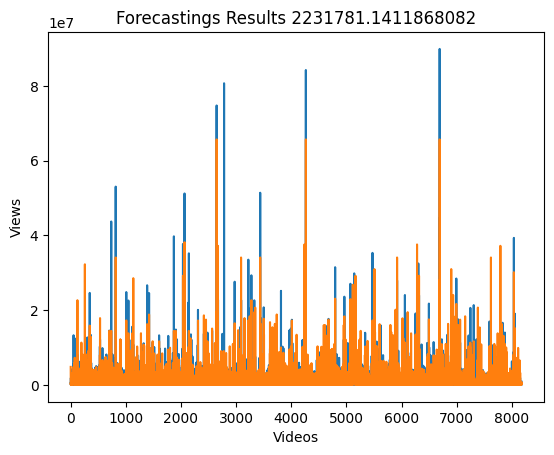

In [108]:
import matplotlib.pyplot as plt

plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pred)
#plt.xlim(0, len(y_test))
plt.title('Forecastings Results '+ str(rmse))
plt.xlabel('Videos')
plt.ylabel('Views')
plt.show()

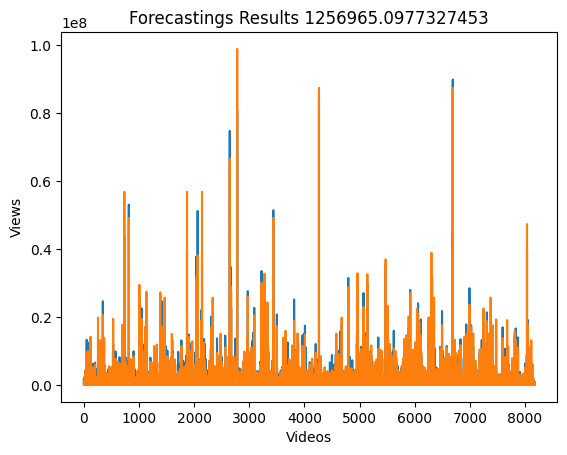

In [105]:
import matplotlib.pyplot as plt

plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pred)
#plt.xlim(0, len(y_test))
plt.title('Forecastings Results '+ str(rmse))
plt.xlabel('Videos')
plt.ylabel('Views')
plt.show()

In [109]:
# Replace NaN values with 0
df_cont= df_cont.fillna(0)

# Save final df as csv
csv_path = "../Data/final_dataset.csv"
df_cont.to_csv(csv_path, index=False)